In [1]:
import firebase_admin
from firebase_admin import db
from datetime import datetime
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cred_obj = firebase_admin.credentials.Certificate("Morphine2.json")
default_app = firebase_admin.initialize_app(cred_obj, {
  'databaseURL':'https://morphine-64cdd-default-rtdb.asia-southeast1.firebasedatabase.app/'
  })

In [3]:
ref_test1 = db.reference("/Test 1")
ref_test2 = db.reference("/Test 2")

In [4]:
# Keywords to extract for each set
keywords = ['Ax: ', 'Ay: ', 'Az: ', 'gx: ', 'gy: ', 'gz: ', 'temp: ', 'timing for this set: ']

# length of each keyword
length_keywords = [len(x) for x in keywords]

In [6]:
# create dataframe to store all the firebase readings
test1_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'aXarr', 'aYarr', 'aZarr', 'gXarr', 'gYarr', 'gZarr', 'tempArr', 'timeDifference'])

In [5]:
test2_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])

In [7]:
# function to extract every variable for one set
def process_set(output_set):
    indexes = [output_set.find(keyword) for keyword in keywords]
    df_row = []
    curr_data_index = int(output_set[:indexes[0]].strip())
    df_row.append(curr_data_index) # append in the index of the new input
    for i, index in enumerate(indexes):
        if i == len(indexes) - 1:
            x = output_set[index+length_keywords[i]:].strip() 
            df_row.append(x)
        else:
            x = output_set[index+length_keywords[i]: indexes[i+1]].strip()
            df_row.append(x)
    return df_row

# function to extract every variables for every data (with 20 sets) read in
def test2_process_esp32_output(esp32_output, timeDifference):
    global test2_df
    accounter = esp32_output['Accounter']
    LoopSpeedArr = esp32_output['LoopSpeedArr'][0]
    UploadSpeedArr = esp32_output['UploadSpeedArr'][0]
    datapoints = esp32_output['datapoints'][0]
    output_sets = datapoints.split('Set: ')[1:]
    for output_set in output_sets:
        datapoint = process_set(output_set)
        data = [accounter, LoopSpeedArr,UploadSpeedArr]
        data.extend(datapoint)
        data.append(timeDifference)
        new_df = pd.DataFrame([data], 
                              columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])
        test2_df = pd.concat([test2_df, new_df], ignore_index = True)
        
def test1_process_esp32_output(esp32_output, timeDifference):
    global test1_df
    accounter = esp32_output['Accounter']
    LoopSpeedArr = esp32_output['LoopSpeedArr'][0]
    UploadSpeedArr = esp32_output['UploadSpeedArr'][0]
    aXarr = esp32_output['aXarr'][0]
    aYarr = esp32_output['aYArr'][0]
    aZarr = esp32_output['aZArr'][0]
    gXarr = esp32_output['gXArr'][0]
    gYarr = esp32_output['gYArr'][0]
    gZarr = esp32_output['gZArr'][0]
    tempArr = esp32_output['tempArr'][0]
    
    data = [accounter, LoopSpeedArr, UploadSpeedArr, aXarr, aYarr, aZarr, gXarr, gYarr, gZarr, tempArr, timeDifference]
    new_df = pd.DataFrame([data], columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'aXarr', 'aYarr', 'aZarr', 'gXarr', 'gYarr', 'gZarr', 'tempArr', 'timeDifference'])
    test1_df = pd.concat([test1_df, new_df], ignore_index = True)

In [ ]:
# Test 1
curr_accounter = ref_test1.get()['Accounter']
curr_time = time.time()
test_1_summary_stats = []
while True:
    new_accounter = ref_test1.get()['Accounter']
    # print(new_accounter, curr_accounter)
    if new_accounter != curr_accounter:
        end_time = time.time()
        test1_process_esp32_output(ref_test1.get(), end_time - curr_time)
        test_1_summary_stats.append(end_time - curr_time)
        print(f"curr_accounter: {curr_accounter}, new_accounter: {new_accounter}, time taken: {end_time - curr_time}")
        curr_accounter = new_accounter
        curr_time = end_time

In [ ]:
# Test 2
curr_accounter = ref_test2.get()['Accounter']
curr_time = time.time()
test_2_summary_stats = []
while True:
    new_accounter = ref_test2.get()['Accounter']
    if new_accounter != curr_accounter:
        end_time = time.time()
        test2_process_esp32_output(ref_test2.get(), end_time - curr_time)
        test_2_summary_stats.append(end_time - curr_time)
        print(f"curr_accounter: {curr_accounter}, new_accounter: {new_accounter}, time taken: {end_time - curr_time}")
        curr_accounter = new_accounter
        curr_time = end_time

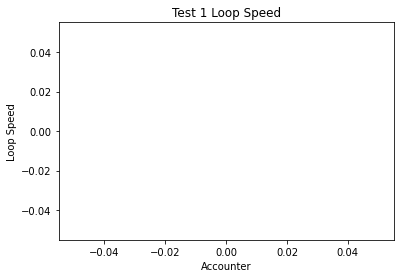

In [10]:
test_1_loop_speed = np.array(test1_df['LoopSpeedArr'])
test_1_x = np.arange(0, len(test_1_loop_speed))
plt.plot(test_1_x, test_1_loop_speed, color ="red")
plt.xlabel("Accounter")
plt.ylabel("Loop Speed")
plt.title("Test 1 Loop Speed")
plt.show()

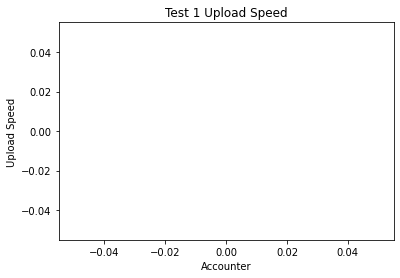

In [11]:
test_1_upload_speed = np.array(test1_df['UploadSpeedArr'])
test_1_x = np.arange(0, len(test_1_upload_speed))
plt.plot(test_1_x, test_1_upload_speed, color ="blue")
plt.xlabel("Accounter")
plt.ylabel("Upload Speed")
plt.title("Test 1 Upload Speed")
plt.show()

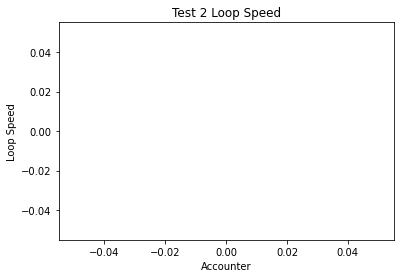

In [13]:
test_2_loop_speed = np.array(test2_df['LoopSpeedArr'])
test_2_x = np.arange(0, len(test_2_loop_speed))
plt.plot(test_2_x, test_2_loop_speed, color ="red")
plt.xlabel("Accounter")
plt.ylabel("Loop Speed")
plt.title("Test 2 Loop Speed")
plt.show()

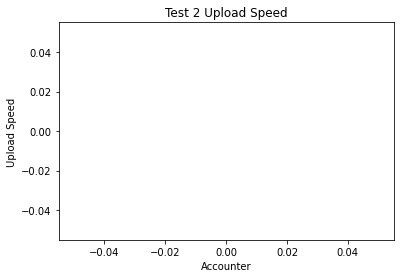

In [14]:
test_2_upload_speed = np.array(test2_df['UploadSpeedArr'])
test_2_x = np.arange(0, len(test_2_upload_speed))
plt.plot(test_2_x, test_2_upload_speed, color ="blue")
plt.xlabel("Accounter")
plt.ylabel("Upload Speed")
plt.title("Test 2 Upload Speed")
plt.show()

In [12]:
np.savetxt("test_1_loop_speed.txt", test_1_loop_speed)
np.savetxt("test_1_upload_speed.txt", test_1_upload_speed)

In [55]:
np.savetxt("test_2_loop_speed.txt", test_2_loop_speed)
np.savetxt("test_2_upload_speed.txt", test_2_upload_speed)